MY ResNet50

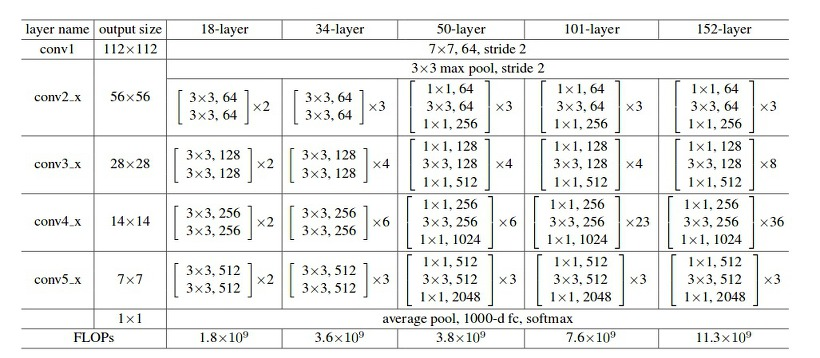

In [4]:
import numpy as np

np.zeros(3)

array([0., 0., 0.])

In [2]:
# import Modules

import numpy as np
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [3]:
# Create Model

class single_block(nn.Module):
  def __init__(self, input_size, channel_size, first_stride):
    super(single_block, self).__init__()
    self.stride = first_stride
    self.block = nn.Sequential(
      nn.Conv2d(input_size, channel_size[0], kernel_size=1, padding=0, stride=first_stride),
      nn.BatchNorm2d(channel_size[0]),
      nn.ReLU(),
      nn.Conv2d(channel_size[0], channel_size[1], kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(channel_size[1]),
      nn.ReLU(),
      nn.Conv2d(channel_size[1], channel_size[2], kernel_size=1, padding=0, stride=1),
      nn.BatchNorm2d(channel_size[2]),
    )
    if self.stride == 2:
      self.strider = nn.Sequential(
        nn.Conv2d(input_size, channel_size[2], kernel_size=1, padding=0, stride=2),
        nn.BatchNorm2d(channel_size[2]),
      )

  def forward(self, x):
    origin = x
    y = self.block(x)
    if self.stride == 2:
      origin = self.strider(x)
    y += origin
    return F.relu(y)


class myResNet50(nn.Module):
  def __init__(self, num_class):
    super(myResNet50, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
      self.repeatable_block(64, [64, 64, 256], repeats=3)
    )
    self.conv3 = self.repeatable_block(256, [128, 128, 512], repeats=4)
    self.conv4 = self.repeatable_block(512, [256, 256, 1024], repeats=6)
    self.conv5 = self.repeatable_block(1024, [512, 512, 2048], repeats=3)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(2048, num_class)

  def repeatable_block(self, input_size, channel_size, repeats=1):
    stride = 2
    block = []
    for i in range(repeats):
      block.append(single_block(input_size, channel_size, stride))
      input_size = channel_size[2]
      stride = 1
    return nn.Sequential(*block)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = self.avgpool(x)
    x = x.squeeze()
    x = self.fc(x)
    return x

In [1]:
# Run Training

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10 Datasets', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

evalset = torchvision.datasets.CIFAR10(root='./CIFAR10 Datasets', train=False, transform=transform)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=256, shuffle=False)

model = myResNet50(10)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)

avg_losses = []
train_acc = []
eval_acc = []
epochs = 100
for epoch in range(epochs):
    start = time.time()
    loss_sum = 0.0
    correct = 0
    total = 0
    model.train()
    for i, data in enumerate(trainloader, 0):
        img, label = data
        img, label = img.cuda(), label.cuda()

        optimizer.zero_grad()
        outputs = model(img)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        loss_sum += loss

        _, prediction = torch.max(outputs, 1)
        total += label.size(0)
        correct += (prediction == label).sum().item()
    avg_loss = loss_sum / len(trainloader)
    avg_losses.append(avg_loss)
    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print('(Train) [epoch : %d] loss: %.3f | time: %.3f | acc: %.3f' % (epoch + 1, avg_loss, (time.time()-start), accuracy))

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(evalloader, 0):
            img, label = data
            img, label = img.cuda(), label.cuda()
            
            outputs = model(img)
            _, prediction = torch.max(outputs, 1)
            total += label.size(0)
            correct += (prediction == label).sum().item()
    accuracy = 100 * correct / total
    eval_acc.append(accuracy)
    print('(Eval) [epoch : %d] acc: %.3f' % (epoch + 1, accuracy))

print('Training Ended')

NameError: name 'torchvision' is not defined

In [8]:
f_acc = open('my_ResNet50_accuracy.csv', "w", encoding="UTF-8")
f_acc.write("epoch, loss, train accuracy, eval accuracy\n")
for i in range(epochs):
    f_acc.write(str(i+1) + ',' + str(avg_losses[i].item()) + ',' + str(train_acc[i]) + ',' + str(eval_acc[i]) + '\n')
f_acc.close()